# Metapredictor For Enhancer Activity Prediction


**Authorship:**
Adam Klie, *09/26/2021*
***
**Description:**
Notebook to train preliminary Gradient Boosting Machine classifiers for predicting enhancer activity
***
**TODOs:**
 - <font color='green'> Done TODO </font>
 - <font color='orange'> WIP TODO </font>
 - <font color='red'> Queued TODO </font>
***

In [1]:
# Classics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Loading webpages
from scipy import stats

import pickle

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [2]:
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
import project_utils

# Engineered feature based predictor

In [7]:
DATASET = "2021-OLS-Library"  # Which dataset to look at
FEATURES = "mixed-2.0"  # What features to use to train the model
LABELS = "binary"
MODEL = "GBM"
PREPROCESS = "0.18-0.4"  # Preprocessing steps, separated by "-"
HYPERPARAM = "selected"
SPLIT = 0.9

## Load Data

In [4]:
X_train = np.load('../data/{0}/{1}/{2}_X-train-{3}_{4}.npy'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), PREPROCESS, SPLIT, FEATURES))
X_test = np.load('../data/{0}/{1}/{2}_X-test-{3}_{4}.npy'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), PREPROCESS, round(1-SPLIT, 1), FEATURES))
y_train = np.loadtxt('../data/{0}/{1}/{2}_y-train-{3}_{1}.txt'.format(DATASET.replace("-", "_"), LABELS, PREPROCESS, SPLIT), dtype=int)
y_test = np.loadtxt('../data/{0}/{1}/{2}_y-test-{3}_{1}.txt'.format(DATASET.replace("-", "_"), LABELS, PREPROCESS, round(1-SPLIT, 1)), dtype=int)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((272642, 26), (272642,), (30294, 26), (30294,))

In [5]:
# Load the input identifiers
IDs = np.loadtxt('../data/{0}/id/{1}_id.txt'.format(DATASET.replace("-", "_"), PREPROCESS), dtype=str)
IDs_train = np.loadtxt('../data/{0}/id/{1}_id-train-{2}.txt'.format(DATASET.replace("-", "_"), PREPROCESS, SPLIT), dtype=str)
IDs_test = np.loadtxt('../data/{0}/id/{1}_id-test-{2}.txt'.format(DATASET.replace("-", "_"), PREPROCESS, round(1-SPLIT, 1)), dtype=str)
IDs.shape, IDs_train.shape, IDs_test.shape

((302936,), (272642,), (30294,))

In [6]:
file = "../data/{0}/{1}/{2}_header.txt".format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), FEATURES)
with open(file, "r") as f:
    features = [line.rstrip() for line in f.readlines()]
dataframe = pd.read_csv("../data/{0}/20210728-3.EnhancerTable.ForAdam.FunctionalEnhancers.WT-detected.ABL-notDetected.10R-20U-0.1P.tsv".format(DATASET.replace("-", "_")), sep="\t", na_values="na")
dataframe = dataframe.set_index("NAME")

## Generate Useful Dataframes

In [8]:
train_df = pd.DataFrame(X_train, columns=features, index=IDs_train)
train_df = pd.merge(dataframe, train_df, left_index=True, right_index=True)
train_df["ACTIVITY_SUMRNA_NUMDNA"].replace(np.inf, np.nan, inplace=True)
train_df = train_df[np.abs(stats.zscore(train_df["ACTIVITY_SUMRNA_NUMDNA"], nan_policy="omit")) < 3]

In [9]:
test_df = pd.DataFrame(X_test, columns=features, index=IDs_test)
test_df = pd.merge(dataframe, test_df, left_index=True, right_index=True)
test_df["ACTIVITY_SUMRNA_NUMDNA"].replace(np.inf, np.nan, inplace=True)
test_df = test_df[np.abs(stats.zscore(test_df["ACTIVITY_SUMRNA_NUMDNA"], nan_policy="omit")) < 3]

## Load Model

In [10]:
file = '../{0}/{1}_{2}_{0}-clf_{3}.pickle'.format(MODEL, PREPROCESS, FEATURES, HYPERPARAM)
clf = pickle.load(open(file, 'rb'))

## Generate predictions

In [11]:
y_tr_preds = clf.predict(X_train)
y_preds = clf.predict(X_test)

In [12]:
y_tr_probs = clf.predict_proba(X_train)[:, 1]
y_probs = clf.predict_proba(X_test)[:, 1]

## Add predictions

In [13]:
clf_train_df = pd.DataFrame(index=IDs_train, data={"labels": y_train, "{}_preds".format(MODEL):y_tr_preds, "{}_probability".format(MODEL):y_tr_probs})
clf_train_df.index.name = "NAME"
train_df = pd.merge(train_df, clf_train_df, left_index=True, right_index=True)
train_df["{}_classification".format(MODEL)] = ["-".join(list(value)) for value in train_df[["labels", "{}_preds".format(MODEL)]].values.astype(str)]
train_df["{}_classification".format(MODEL)] = train_df["{}_classification".format(MODEL)].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
train_df["{}_classification".format(MODEL)].value_counts()

TN    174507
FN     49862
TP     31416
FP     13284
Name: GBM_classification, dtype: int64

In [14]:
clf_test_df = pd.DataFrame(index=IDs_test, data={"labels": y_test, "{}_preds".format(MODEL):y_preds, "{}_probability".format(MODEL):y_probs})
clf_test_df.index.name = "NAME"
test_df = pd.merge(test_df, clf_test_df, left_index=True, right_index=True)
test_df["{}_classification".format(MODEL)] = ["-".join(list(value)) for value in test_df[["labels", "{}_preds".format(MODEL)]].values.astype(str)]
test_df["{}_classification".format(MODEL)] = test_df["{}_classification".format(MODEL)].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
test_df["{}_classification".format(MODEL)].value_counts()

TN    19406
FN     5503
TP     3455
FP     1532
Name: GBM_classification, dtype: int64

# Sequence based predictor

In [15]:
DATASET = "2021-OLS"  # Which dataset to look at
FEATURES = "fasta"  # What features to use to train the model
LABELS = "binary"
MODEL = "gkSVM"
PREPROCESS = "0.18-0.4"  # Preprocessing steps, separated by "-"
HYPERPARAM = "baseline-positive-weighted"
SPLIT = 0.9

## Load Model Predictions

In [16]:
# Make sure ordering is correct
if MODEL == "gkSVM":
    pos_tr_scores = pd.read_csv('../gkSVM/Result_{0}-X-fasta_{1}_{2}/{0}-X-fasta_{1}_{2}.tr.predict.txt'.format(DATASET, PREPROCESS, HYPERPARAM), delim_whitespace=True, header=None, names=["NAME", "gkSVM_probability"])
    neg_tr_scores = pd.read_csv('../gkSVM/Result_{0}-X-fasta_{1}_{2}/{0}-X-fasta_{1}_{2}.neg.tr.predict.txt'.format(DATASET, PREPROCESS, HYPERPARAM), delim_whitespace=True, header=None, names=["NAME", "gkSVM_probability"])
    pos_scores = pd.read_csv('../gkSVM/Result_{0}-X-fasta_{1}_{2}/{0}-X-fasta_{1}_{2}.predict.txt'.format(DATASET, PREPROCESS, HYPERPARAM), delim_whitespace=True, header=None, names=["NAME", "gkSVM_probability"])
    neg_scores = pd.read_csv('../gkSVM/Result_{0}-X-fasta_{1}_{2}/{0}-X-fasta_{1}_{2}.neg.predict.txt'.format(DATASET, PREPROCESS, HYPERPARAM), delim_whitespace=True, header=None, names=["NAME", "gkSVM_probability"])   
    pos_scores["gkSVM_labels"] = 1
    pos_tr_scores["gkSVM_labels"] = 1
    neg_scores["gkSVM_labels"] = 0
    neg_tr_scores["gkSVM_labels"] = 0
    pos_scores["gkSVM_preds"] = (pos_scores["gkSVM_probability"] >= 0).astype(int)
    pos_tr_scores["gkSVM_preds"] = (pos_tr_scores["gkSVM_probability"] >= 0).astype(int)
    neg_scores["gkSVM_preds"] = (neg_scores["gkSVM_probability"] >= 0).astype(int)
    neg_tr_scores["gkSVM_preds"] = (neg_tr_scores["gkSVM_probability"] >= 0).astype(int)
    clf_train_df = pd.concat([pos_tr_scores, neg_tr_scores]).set_index("NAME")
    clf_test_df = pd.concat([pos_scores, neg_scores]).set_index("NAME")
    print(len(pos_tr_scores), len(neg_tr_scores), len(pos_scores), len(neg_scores))

84851 187791 9356 20938


## Add Model Predictions

In [17]:
train_df = pd.merge(train_df, clf_train_df, left_index=True, right_index=True)
train_df["{}_classification".format(MODEL)] = ["-".join(list(value)) for value in train_df[["labels", "{}_preds".format(MODEL)]].values.astype(str)]
train_df["{}_classification".format(MODEL)] = train_df["{}_classification".format(MODEL)].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
train_df["{}_classification".format(MODEL)].value_counts()

TN    164610
TP     41963
FN     39315
FP     23181
Name: gkSVM_classification, dtype: int64

In [18]:
test_df = pd.merge(test_df, clf_test_df, left_index=True, right_index=True)
test_df["{}_classification".format(MODEL)] = ["-".join(list(value)) for value in test_df[["labels", "{}_preds".format(MODEL)]].values.astype(str)]
test_df["{}_classification".format(MODEL)] = test_df["{}_classification".format(MODEL)].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
test_df["{}_classification".format(MODEL)].value_counts()

TN    18305
TP     4590
FN     4368
FP     2633
Name: gkSVM_classification, dtype: int64

In [21]:
# Percent agreement between the two in terms of classification
(test_df["GBM_classification"] == test_df["gkSVM_classification"]).sum()/len(test_df)

0.8746320578003747

# Visualize Correlations

0.7211253541087589


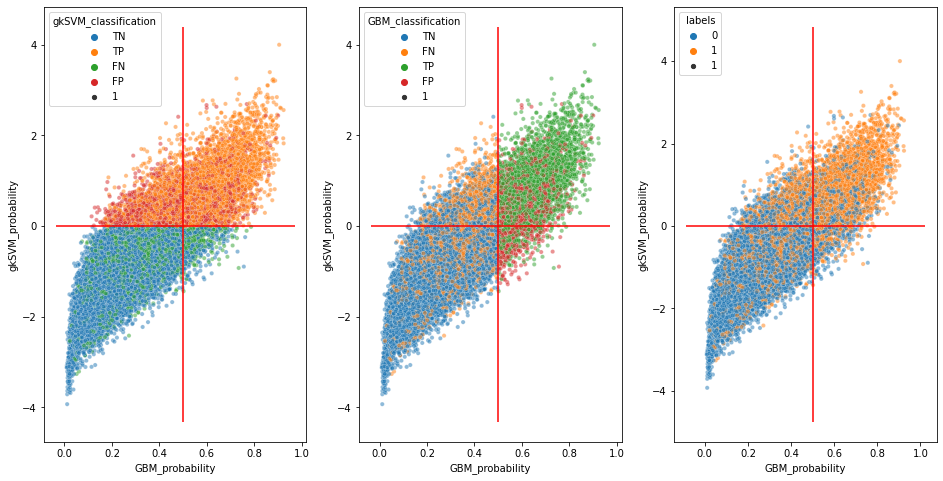

In [116]:
fig, ax = plt.subplots(1, 3, figsize=(16,8))
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.scatterplot(data=test_df, x="GBM_probability", y="gkSVM_probability", hue="gkSVM_classification", size=1, alpha=0.5, ax=ax[0])
ax[0].hlines(0, ax[0].get_xlim()[0], ax[0].get_xlim()[1], color="red")
ax[0].vlines(0.5, ax[0].get_ylim()[0], ax[0].get_ylim()[1], color="red")

sns.scatterplot(data=test_df, x="GBM_probability", y="gkSVM_probability", hue="GBM_classification", size=1, alpha=0.5, ax=ax[1])
ax[1].hlines(0, ax[1].get_xlim()[0], ax[1].get_xlim()[1], color="red")
ax[1].vlines(0.5, ax[1].get_ylim()[0], ax[1].get_ylim()[1], color="red")

sns.scatterplot(data=test_df, x="GBM_probability", y="gkSVM_probability", hue="labels", size=1, alpha=0.5, ax=ax[2])
ax[2].hlines(0, ax[1].get_xlim()[0], ax[1].get_xlim()[1], color="red")
ax[2].vlines(0.5, ax[1].get_ylim()[0], ax[1].get_ylim()[1], color="red")

print(r2(test_df["GBM_probability"], test_df["gkSVM_probability"]))

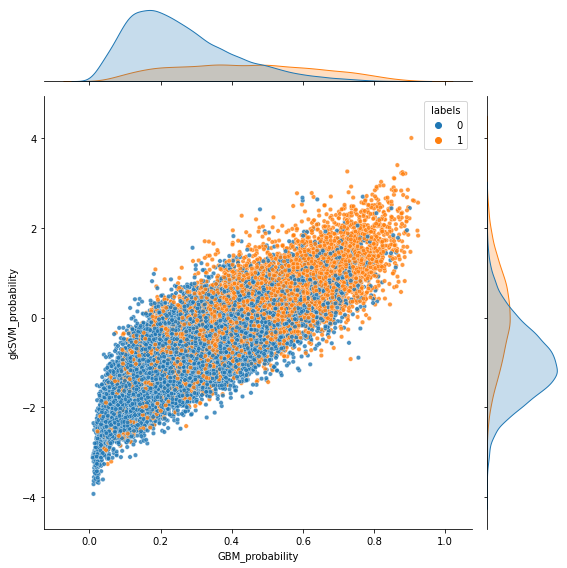

In [172]:
sns.jointplot(data=test_df, x="GBM_probability", y="gkSVM_probability", hue="labels", kind="scatter", alpha=0.8, s = 20, height=8)

# Train metapredictors

## Feature based with sequence prob as a feature

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [48]:
X_train, y_train = train_df[features+["gkSVM_probability"]].values, train_df["labels"].values
X_test, y_test = test_df[features+["gkSVM_probability"]].values, test_df["labels"].values

In [49]:
meta_clf = GradientBoostingClassifier(n_estimators=1000, random_state=13, verbose=1)
print("Training new GBM with the following params: {}".format(clf.get_params()))
meta_clf.fit(X_train, y_train)

Training new GBM with the following params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_iter_no_change': None, 'random_state': 13, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 1, 'warm_start': False}
      Iter       Train Loss   Remaining Time 
         1           1.1822            8.63m
         2           1.1488            8.51m
         3           1.1222            8.32m
         4           1.1007            8.27m
         5           1.0832            8.24m
         6           1.0687            8.23m
         7           1.0568            8.20m
         8           1.0469            8.20m
         9           1.0387            8.18m
        10           1.0319          

GradientBoostingClassifier(n_estimators=1000, random_state=13, verbose=1)

In [50]:
y_train_preds = meta_clf.predict(X_train)
y_test_preds = meta_clf.predict(X_test)

In [51]:
y_train_probs = meta_clf.predict_proba(X_train)[:, 1]
y_test_probs = meta_clf.predict_proba(X_test)[:, 1]

Generating confusion matrix
Calculating classification metrics
Metric	Train	Test
Accuracy	0.7817	0.7791
Precision	0.7181	0.7065
Recall	0.4564	0.4495
F0.1-Score	0.7140	0.7025
F0.5-Score	0.6442	0.6340
F1-Score	0.5581	0.5495
F2-Score	0.4923	0.4848
F10-Score	0.4581	0.4512
Plotting PR Curve
Plotting ROC Curve
Generating report


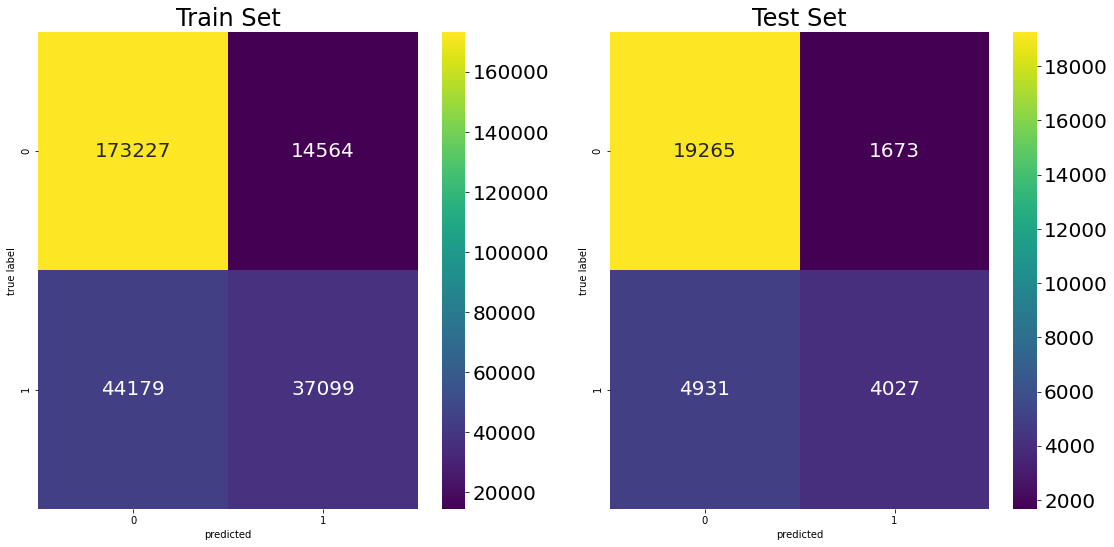

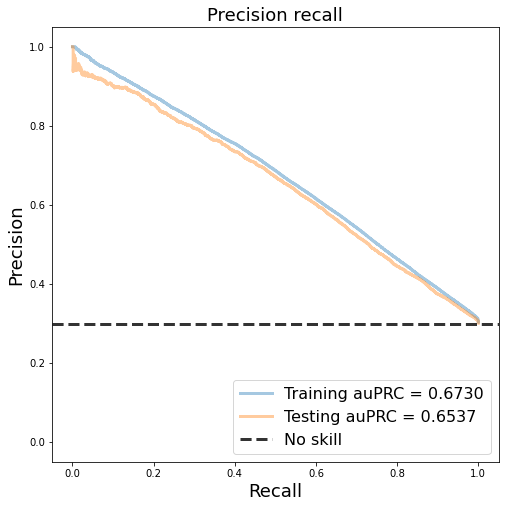

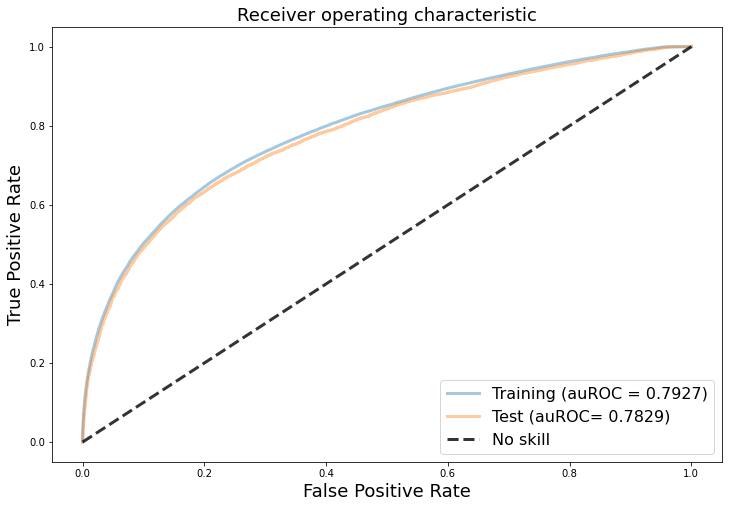

In [52]:
project_utils.classification_report(filename="{}_META-Classificaton-Report.md".format(PREPROCESS),
                                    md_title="{}_META-Classificaton-Report".format(PREPROCESS),
                                    clf=meta_clf, train_X=X_train, test_X=X_test, train_y=y_train, test_y=y_test)
    

In [53]:
from sklearn.inspection import permutation_importance

In [56]:
feature_names = features + ["gkSVM_probability"]

In [59]:
import time
start_time = time.time()
result = permutation_importance(
    meta_clf, X_test, y_test, n_repeats=10, random_state=12, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)


Elapsed time to compute the importances: 64.771 seconds


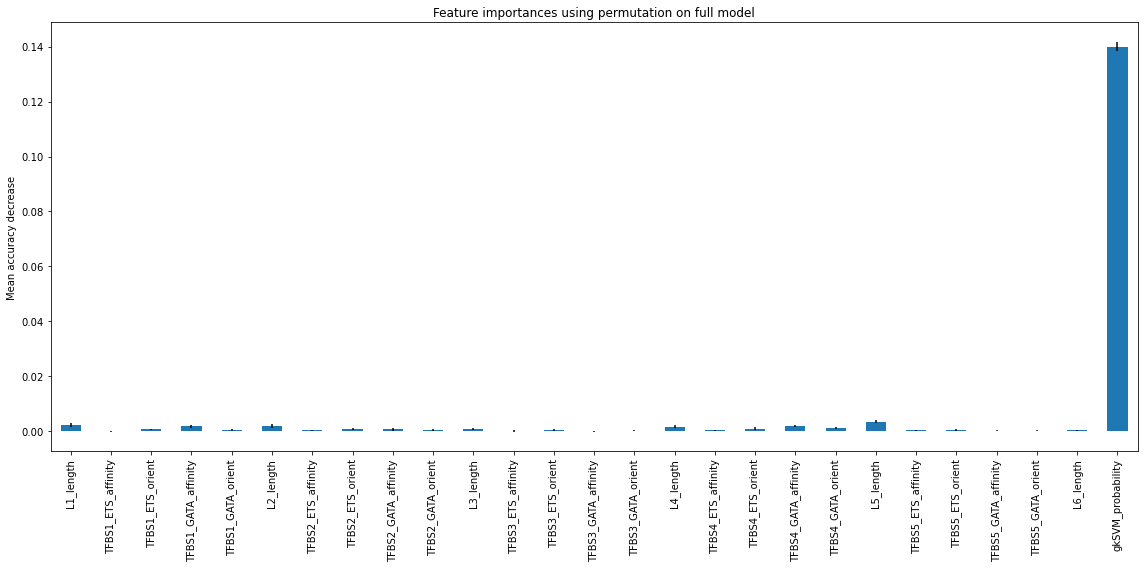

In [62]:
fig, ax = plt.subplots(figsize=(16,8))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Logistic regression with feature and sequence based probabilities

In [24]:
X_train, y_train = train_df[["GBM_probability", "gkSVM_probability"]].values, train_df["labels"].values

In [25]:
X_test, y_test = test_df[["GBM_probability", "gkSVM_probability"]].values, test_df["labels"].values

In [27]:
X_train.shape, X_test.shape

((269069, 2), (29896, 2))

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
scaler = StandardScaler()

In [37]:
scaler.fit(X_train)

StandardScaler()

In [39]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
meta_clf = LogisticRegression()

In [41]:
meta_clf.fit(X_train, y_train)

LogisticRegression()

In [42]:
y_train_preds = meta_clf.predict(X_train)
y_test_preds = meta_clf.predict(X_test)

In [43]:
y_train_probs = meta_clf.predict_proba(X_train)[:, 1]
y_test_probs = meta_clf.predict_proba(X_test)[:, 1]

Generating confusion matrix
Calculating classification metrics
Metric	Train	Test
Accuracy	0.7763	0.7760
Precision	0.7003	0.6947
Recall	0.4535	0.4503
F0.1-Score	0.6966	0.6910
F0.5-Score	0.6316	0.6267
F1-Score	0.5505	0.5464
F2-Score	0.4879	0.4844
F10-Score	0.4550	0.4519
Plotting PR Curve
Plotting ROC Curve
Generating report


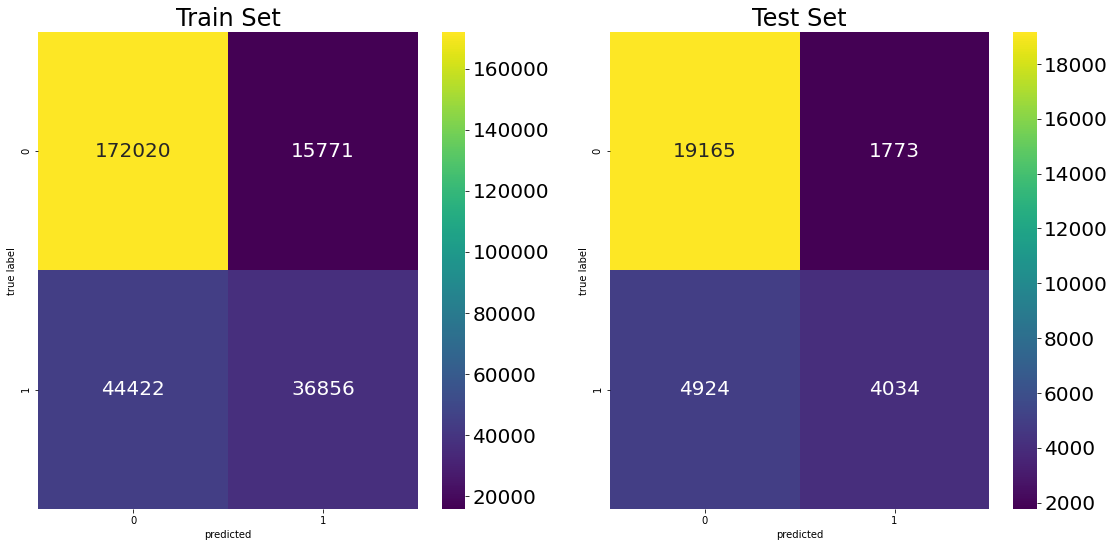

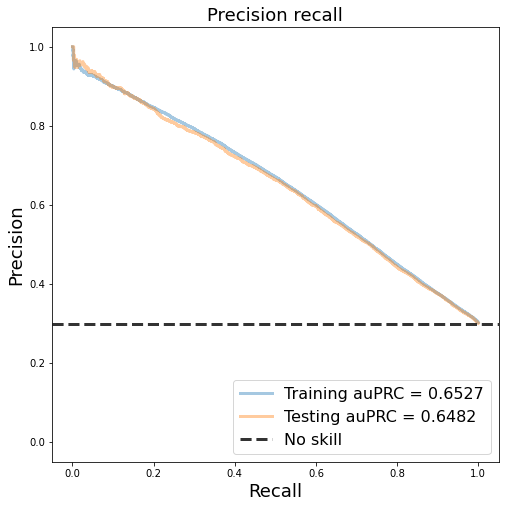

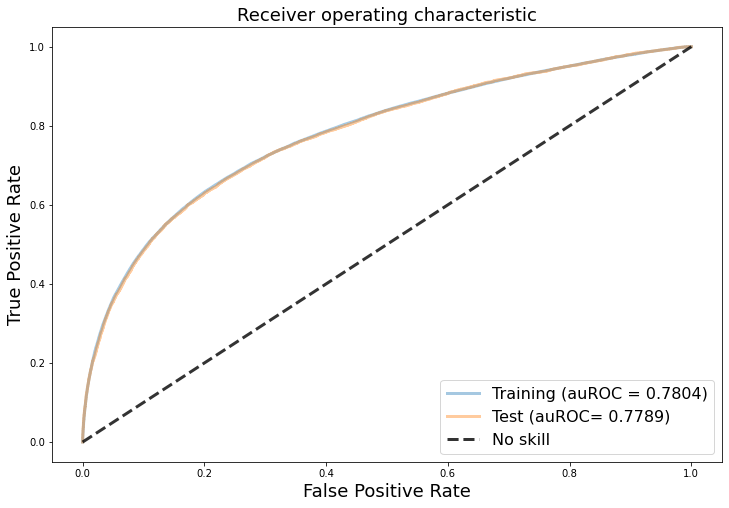

In [44]:
project_utils.classification_report(filename="{}_META-probs-Classificaton-Report.md".format(PREPROCESS),
                                    md_title="{}_META-probs-Classificaton-Report".format(PREPROCESS),
                                    clf=meta_clf, train_X=X_train, test_X=X_test, train_y=y_train, test_y=y_test)

In [46]:
meta_clf.coef_

array([[0.53613869, 0.70874184]])

## AND/OR models

In [110]:
test_df["meta_OR_preds"] = (test_df["gkSVM_preds"] | test_df["GBM_preds"])

In [111]:
test_df["meta_AND_preds"] = (test_df["gkSVM_preds"] & test_df["GBM_preds"])

In [119]:
(test_df["meta_AND_preds"] == test_df["labels"]).mean()

0.7675608777093925

In [120]:
(test_df["meta_OR_preds"] == test_df["labels"]).mean()

0.762944875568638

In [123]:
test_df["meta_OR_classification"] = ["-".join(list(value)) for value in test_df[["labels", "meta_OR_preds"]].values.astype(str)]
test_df["meta_OR_classification"] = test_df["meta_OR_classification"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
test_df["meta_OR_classification"].value_counts()

TN    17884
TP     4925
FN     4033
FP     3054
Name: meta_OR_classification, dtype: int64

In [124]:
test_df["meta_AND_classification"] = ["-".join(list(value)) for value in test_df[["labels", "meta_AND_preds"]].values.astype(str)]
test_df["meta_AND_classification"] = test_df["meta_AND_classification"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
test_df["meta_AND_classification"].value_counts()

TN    19827
FN     5838
TP     3120
FP     1111
Name: meta_AND_classification, dtype: int64

# Scratch

# References